Create Simple NN with PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

Task 1: Loading and Visualizing MNIST Dataset

In [2]:
from torchvision import datasets,transforms as T

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

In [4]:
trainset = datasets.MNIST('MNIST_data/', download= False, train= True, transform= transform)

In [5]:
print(len(trainset))

60000


In [6]:
testset = datasets.MNIST('MNIST_data/', download= False, train= False, transform= transform)

In [7]:
print(len(testset))

10000


Text(0.5, 1.0, '1')

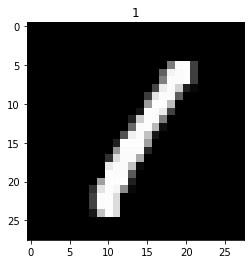

In [8]:
idx = 3
image , label = trainset[idx]
plt.imshow(image.numpy().squeeze(),cmap ='gray')
plt.title(label)

Task 2 : Spliting Dataset, Setting Dataloader

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.2
num_train = len(trainset) #60000 
split= int(np.floor(valid_size * num_train)) # 12000
indices = list(range(num_train)) # [0,1,2, ...59999]
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

In [10]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [11]:
trainloader = DataLoader(trainset, batch_size=64, sampler = train_sampler)
validloader = DataLoader(trainset, batch_size=64, sampler = valid_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle= True)

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [13]:
print("Batches in TrainLoader :{}".format(len(trainloader)))
print("Batches in ValidLoader :{}".format(len(validloader)))
print("Batches in TestLoader :{}".format(len(testloader)))

print("Examples in TrainLoader :{}".format(len(trainloader.sampler)))
print("Examples in ValidLoader :{}".format(len(validloader.sampler)))
print("Examples in TestLoader :{}".format(len(testloader.sampler)))

Batches in TrainLoader :750
Batches in ValidLoader :188
Batches in TestLoader :157
Examples in TrainLoader :48000
Examples in ValidLoader :12000
Examples in TestLoader :10000


Task 3 Create NN or Model

In [14]:
from torch import nn
import torch.nn.functional as F

class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.linear1 = nn.Linear(28*28,256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,10)
        self.dropout = nn.Dropout(p = 0.2)
    def forward(self, images):
        images = images.view(images.shape[0], -1) # [64,1,28,28] -> [64, 28*28]
        
        z1 = self.linear1(images)
        a1 = self.dropout(F.relu(z1))
        
        z2 = self.linear2(z1)
        a2 = self.dropout(F.relu(z2))
        
        z3 = self.linear3(z2)
        a3 = F.log_softmax(z3, dim = 1)
        
        return a3 
        

In [15]:
model = Classifier()
model

Classifier(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [16]:
from torchsummary import summary
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# summary(model, input_size = (1,28,28))

Task 4 : Training NN 

In [17]:
from torch import optim
from utils import view_classify, multiclass_accuracy

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr =0.001)
epochs =30


In [18]:
for e in range(epochs):
    train_acc,train_loss,valid_loss, valid_acc = 0.0,0.0,0.0,0.0
    
    model.train()
    for images, labels in trainloader:
#         images = images.to(device)
#         labels = labels.to(device)
        
        logps = model(images)
        ps = torch.exp(logps)
        optimizer.zero_grad()
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc +=multiclass_accuracy(ps,labels)
        
    model.eval()   
    
    for images, labels in validloader:
#         images = images.to(device)
#         labels = labels.to(device)
        logps = model(images)
        ps = torch.exp(logps)
        loss = criterion(logps,labels)
        valid_acc += multiclass_accuracy(ps, labels) 
        valid_loss += loss.item()
        
    train_loss /= len(trainloader)
    valid_loss /= len(validloader)
    valid_acc /= len(validloader)
    train_acc /= len(trainloader)
    print("Epoch : {} Train loss : {:.4f} Valid_loss : {:.4f} Valid_Acc: {} Train Acc: {}".format(e+1,train_loss,valid_loss,valid_acc,train_acc))

Epoch : 1 Train loss : 0.4387 Valid_loss : 0.3642 Valid_Acc: 0.891954779624939 Train Acc: 0.8687291741371155
Epoch : 2 Train loss : 0.3546 Valid_loss : 0.3562 Valid_Acc: 0.8996841907501221 Train Acc: 0.8979583382606506
Epoch : 3 Train loss : 0.3384 Valid_loss : 0.3673 Valid_Acc: 0.8928689956665039 Train Acc: 0.9027291536331177
Epoch : 4 Train loss : 0.3324 Valid_loss : 0.3568 Valid_Acc: 0.8981881737709045 Train Acc: 0.9044583439826965
Epoch : 5 Train loss : 0.3248 Valid_loss : 0.3713 Valid_Acc: 0.896276593208313 Train Acc: 0.9072499871253967
Epoch : 6 Train loss : 0.3219 Valid_loss : 0.3326 Valid_Acc: 0.905834436416626 Train Acc: 0.9073541760444641
Epoch : 7 Train loss : 0.3159 Valid_loss : 0.3310 Valid_Acc: 0.905418872833252 Train Acc: 0.9087916612625122
Epoch : 8 Train loss : 0.3105 Valid_loss : 0.3794 Valid_Acc: 0.8908743262290955 Train Acc: 0.9120625257492065
Epoch : 9 Train loss : 0.3071 Valid_loss : 0.3373 Valid_Acc: 0.9040060043334961 Train Acc: 0.9120833277702332
Epoch : 10 Tra

Task 5: Evaluating the model 

In [19]:
model.eval()
test_loss , test_acc = 0.0,0.0

for images, labels in testloader:
#     images = images.to(device)
#     labels = labels.to(device)
    
    logps = model(images)
    ps = torch.exp(logps)
    loss = criterion(logps,labels)
    test_acc += multiclass_accuracy(ps, labels) 
    test_loss += loss.item()
test_loss /= len(testloader)
test_acc /= len(testloader)

print("TestL Loss: {} Test Acc: {}".format(test_loss,test_acc))

TestL Loss: 0.2917154675266545 Test Acc: 0.9195860028266907


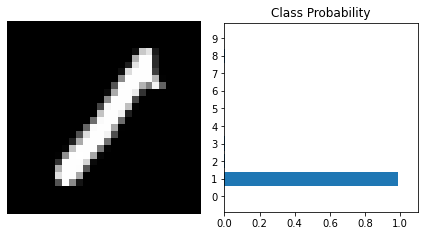

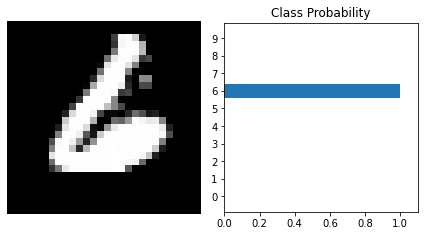

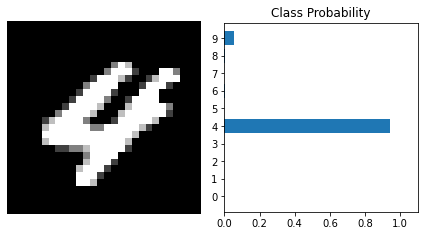

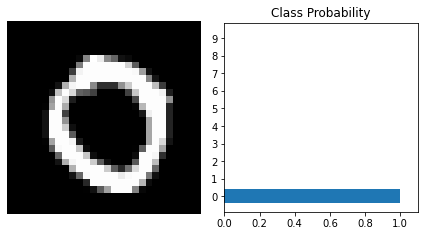

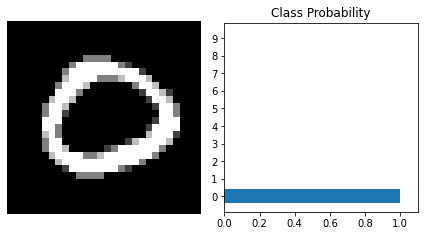

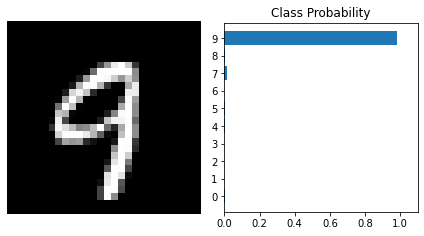

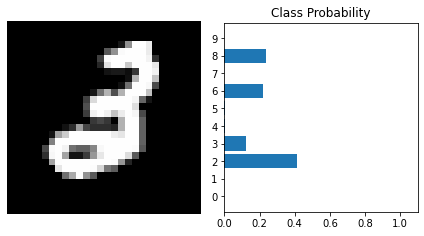

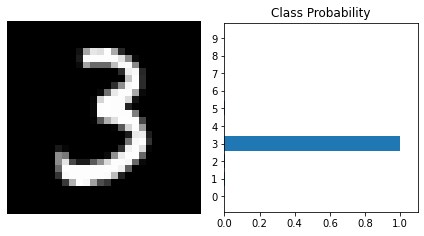

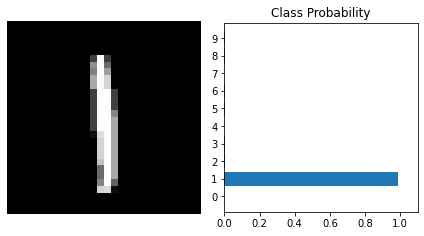

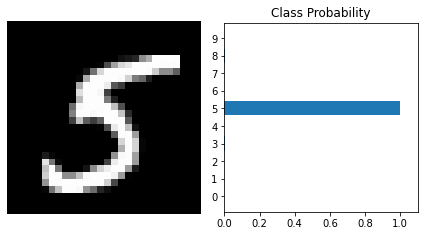

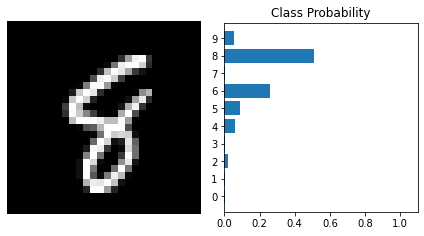

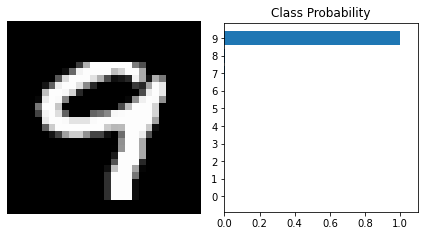

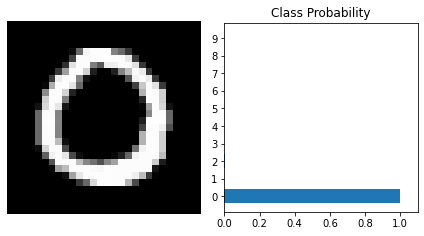

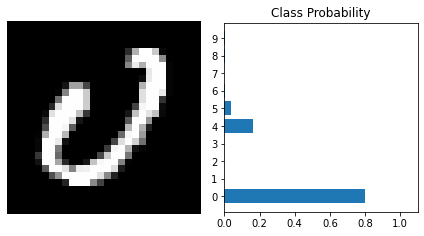

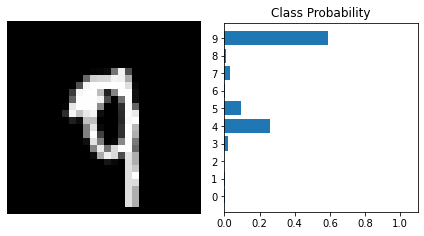

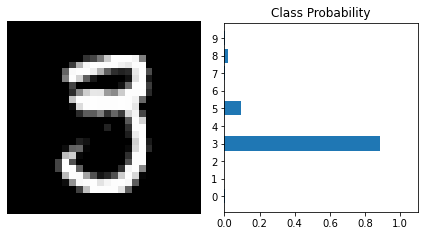

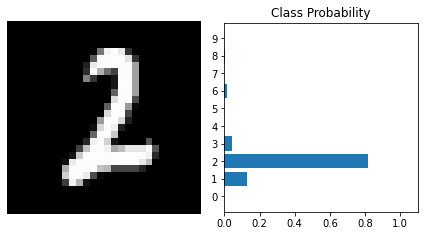

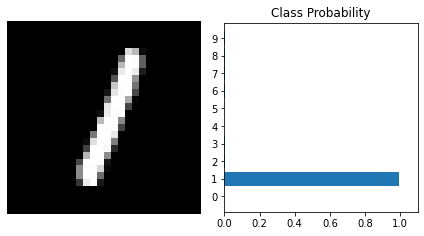

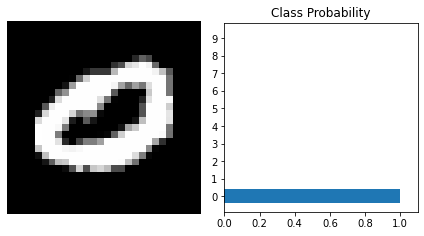

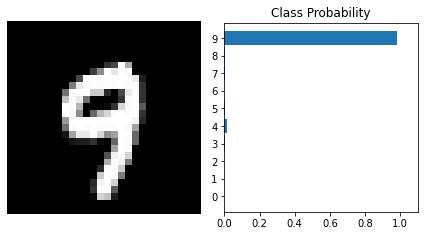

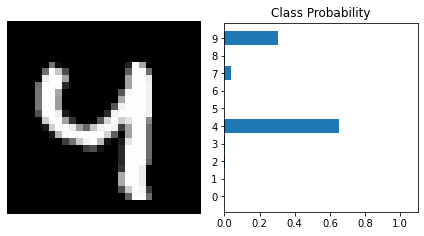

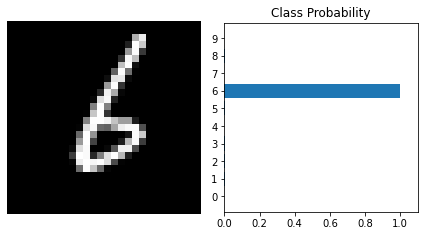

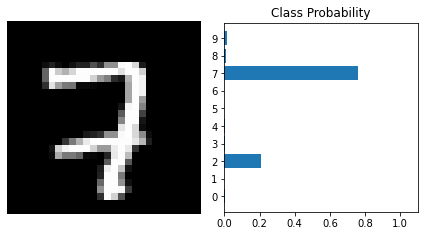

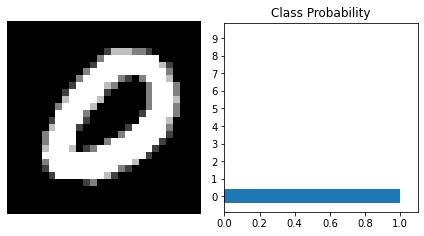

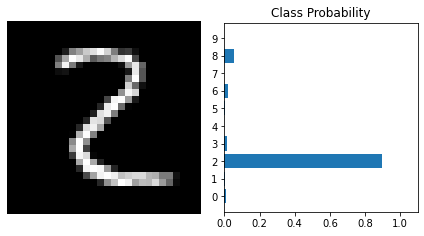

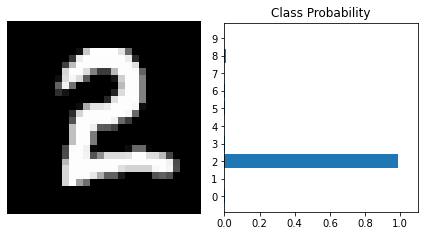

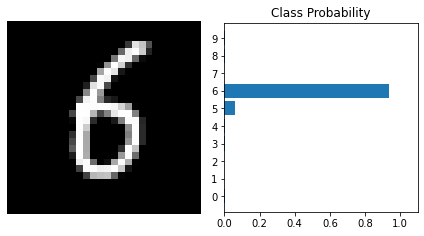

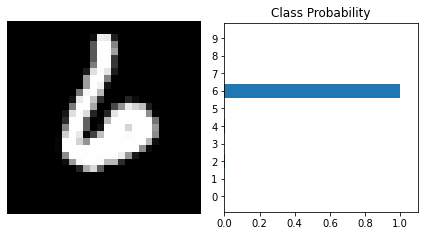

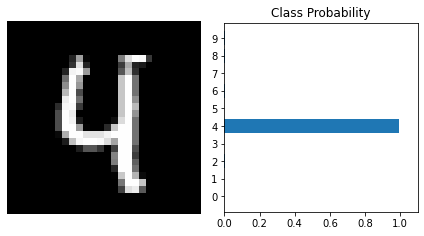

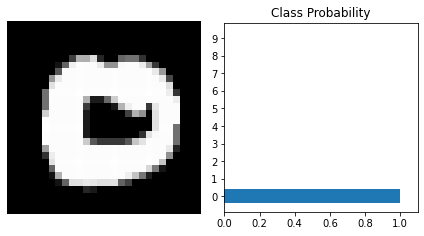

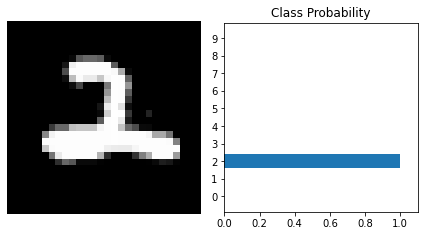

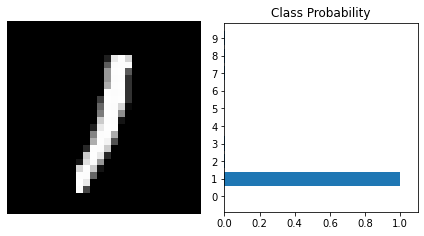

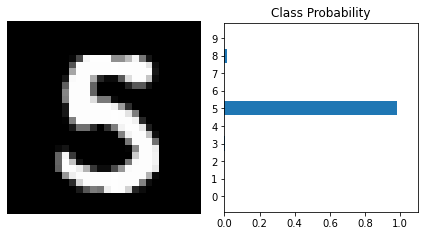

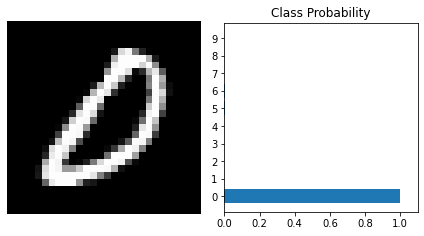

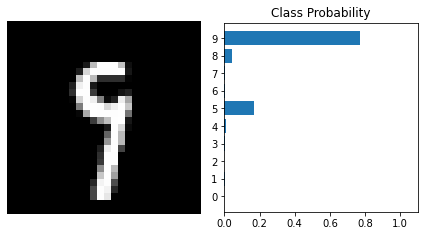

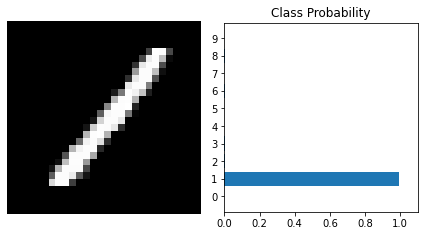

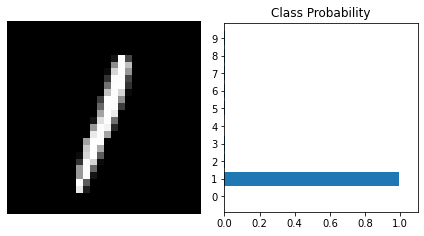

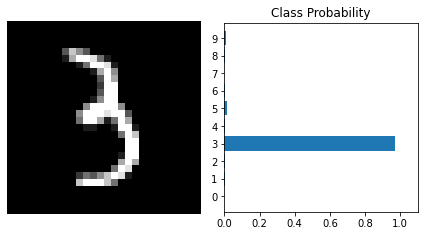

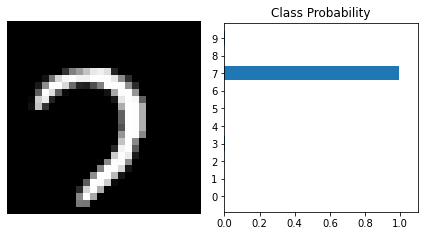

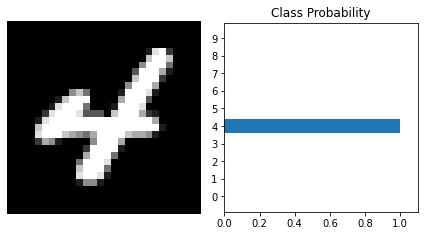

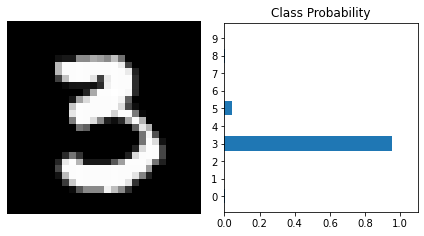

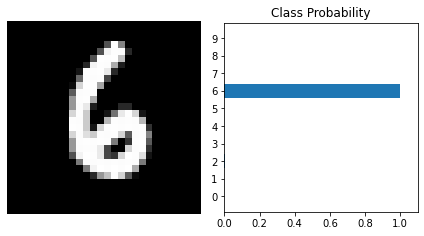

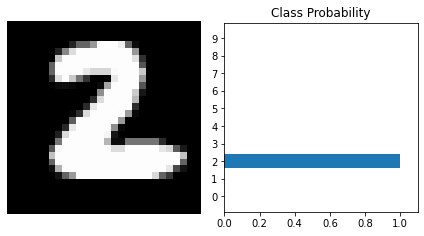

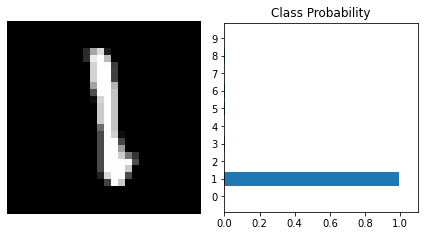

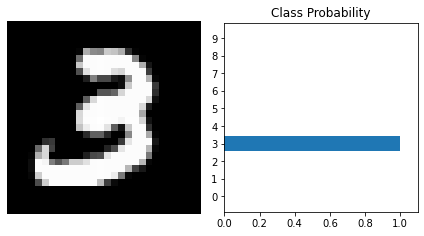

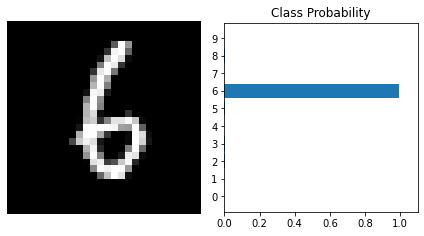

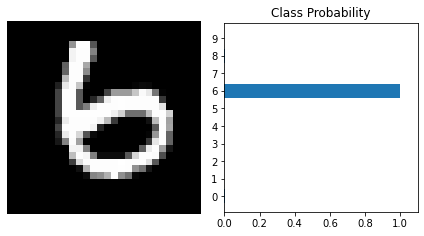

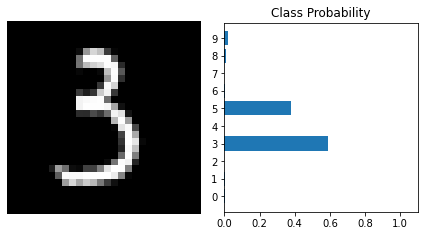

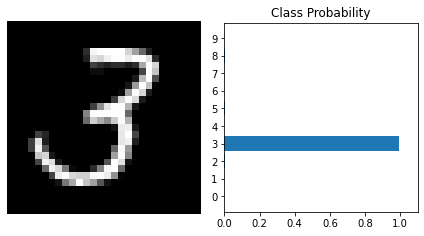

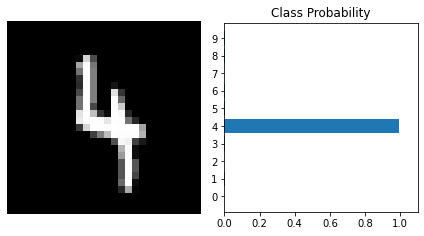

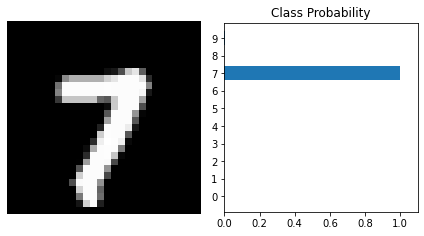

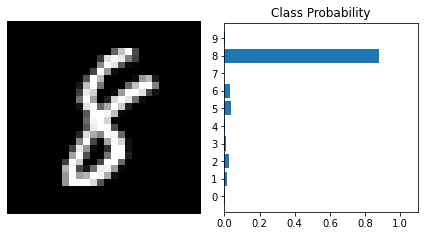

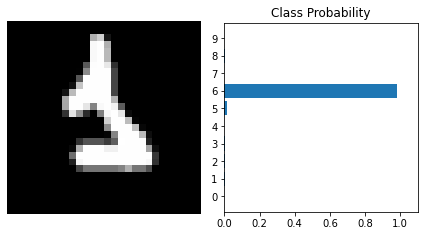

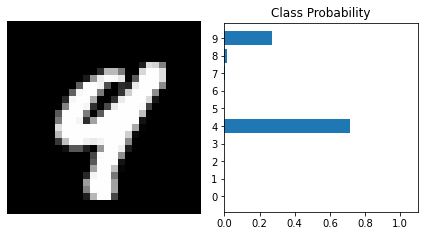

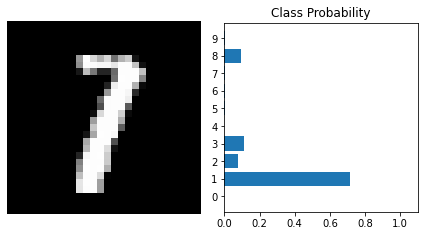

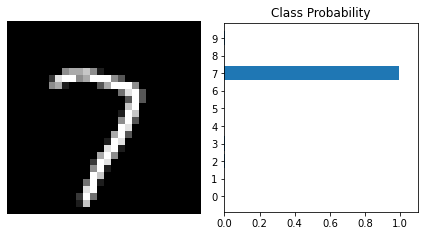

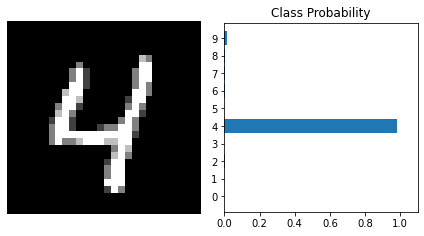

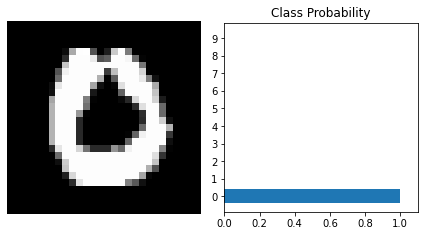

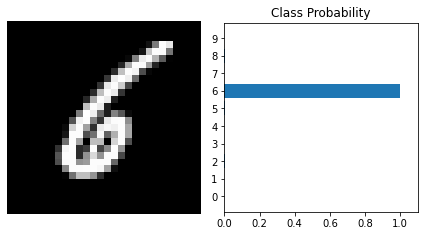

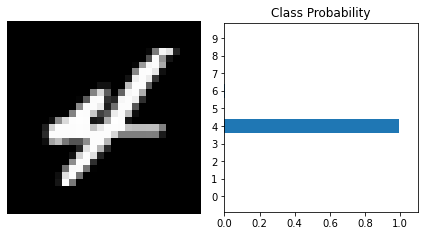

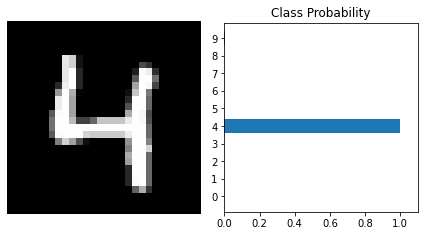

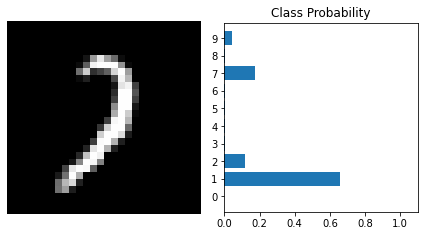

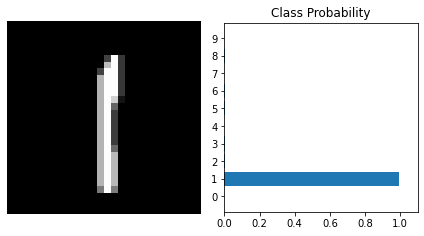

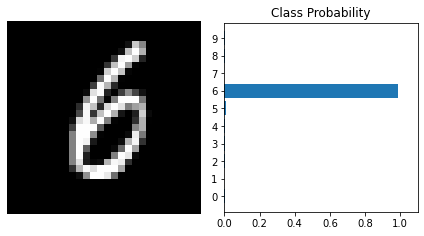

In [23]:
dataiter = iter(testloader)
images , labels = dataiter.next()

# images = images.to(device)
# labels = labels.to(device)

for i in range(64):

    logps = model(images[i])

    ps = torch.exp(logps)

    view_classify(images[i],ps)